In [10]:
import re
import numpy as np
import pandas as pd
import difflib 
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import Image, display


### Load Data

In [3]:

movie_data = pd.read_csv("./data/movies.csv")


In [75]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Cleaning

##### "movie_data" dataset

(1) Separate movie title from year of release.

(2) transform 'genres' column into a vector using one-hot encoding for each row in the dataset. 

Sorted 20-dimensional vector for binary categorical encoding of movie genres: 
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

Complexity of Genre Matrix: 
- dimensions: 20
- rows: 62423

In [106]:
# Data Cleaning

year = []
titles = []
for item in movie_data['title']:
    title_match = re.search(r"^(.*?)\s*\(\d{4}\)$", item)
    year_match = re.search(r"\((\d{4})\)", item)
    if year_match:
        year_extracted = year_match.group(1)
        year.append(year_extracted)
    else:
        year.append('Nan')
    if title_match: 
        title_extracted = title_match.group(1)
        titles.append(title_extracted)
    else:
        titles.append('Nan')

genre_clean = []
for input_string in movie_data["genres"]:
    output_string = re.sub(r'\|', ', ', input_string)
    genre_clean.append([output_string])

# One-Hot Encoding Step
mlb = MultiLabelBinarizer()
genre_one_hot_encoded = mlb.fit_transform([genres[0].split(', ') for genres in genre_clean])

movie_data['movie_title'] = titles
movie_data['year'] = year
movie_data['genre_clean'] = genre_clean
movie_data['genre_one_hot_encoding'] = [arr for arr in genre_one_hot_encoded]
genres = ['No_Genre', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df = pd.DataFrame(genre_one_hot_encoded, columns=genres)

movie_data = pd.concat([movie_data, df], axis=1)

#Example Output
print("   Movie Title:", movie_data.movie_title[0])
print("   Movie Year:", movie_data.year[0])
print("   Genres:", genre_clean[0])
print("   One-Hot Encoding:", genre_one_hot_encoded[0])


   Movie Title: Toy Story
   Movie Year: 1995
   Genres: ['Adventure, Animation, Children, Comedy, Fantasy']
   One-Hot Encoding: [0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


### Cosine Similarity

Compute cosine similarity between all pairs of movies.

The cosine similarity calculation below computes the dot product between the rows of the one_hot_encoded matrix and their transposition (one_hot_encoded.T), resulting in a square matrix where each element (i, j) represents the dot product between rows i and j. The np.linalg.norm(one_hot_encoded, axis=1) computes the norm of each row in the one_hot_encoded matrix. [:, None] is used to convert the 1D array of norms into a column vector. The division operation then calculates the cosine similarity between all pairs of movies.

For time complexity, given 62423 rows of 20-D vectors, calculating cosine similarity for all pairwise combinations requires (62423 * 62423) / 2 = 1,551,732,253 calculations. Assuming each cosine similarity calculation takes approximately 1 microsecond, total time to compute all cosine similarities would be around 1,551 seconds (~ 25 minutes) (e.g., using a for loop). Using NumPy broadcasting, time complexity is reduced by 1 order of magnitude (2.5 x 10 ^ 1 -> 2.5 x 10 ^ 0), requiring only ~ 2.5 minutes for completion. 

In [4]:
# Cosine similarity using L2 Normalization (Euclidean normalization)
cosine_similarity = np.dot(genre_one_hot_encoded, genre_one_hot_encoded.T) / (np.linalg.norm(genre_one_hot_encoded, axis=1)[:, None] * np.linalg.norm(genre_one_hot_encoded, axis=1))
movie_data['genre_cosine_similarity'] = [arr for arr in cosine_similarity]

In [5]:
movie_data.head()

,movieId,title,genres,movie_title,year,genre_clean,genre_one_hot_encoding,No_Genre,Action,Adventure,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre_cosine_similarity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,"[Adventure, Animation, Children, Comedy, Fantasy]","[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.9999999999999998, 0.7745966692414834, 0.316..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995,"[Adventure, Children, Fantasy]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.7745966692414834, 1.0000000000000002, 0.0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,"[Comedy, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,...,0,0,0,0,1,0,0,0,0,"[0.31622776601683794, 0.0, 0.9999999999999998,..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995,"[Comedy, Drama, Romance]","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0,0,0,...,0,0,0,0,1,0,0,0,0,"[0.2581988897471611, 0.0, 0.8164965809277259, ..."
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,[Comedy],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,...,0,0,0,0,0,0,0,0,0,"[0.4472135954999579, 0.0, 0.7071067811865475, ..."


### Find Similar Movies 


#### - String Similarity 

Find similar movies titles based on string similarity. 

In [10]:
# Taking user input
user_movie = 'The Lion King'
# Listing all available movie titles
titles = list(movie_data['movie_title'])
# Specifying max number of close matches
number_of_results = 5
# Finding the most similar movies to the one input by the user
similar_movies = difflib.get_close_matches(user_movie,titles,n=number_of_results, cutoff=0.5)
print(f"Top {number_of_results} matches for '{user_movie}':\n", similar_movies[:number_of_results]) 

Top 5 matches for 'The Lion King':
 ['The Lion King', 'The Giant King', 'The Sun King', 'The Scorpion King', 'The Monkey King']


#### - Cosine Similarity

Find similar movies based on cosine similarity of movie genres. 

In [14]:
# Function to find movie_index based on movie_title
def find_movie_index(movie_df, title):
    movie_index = movie_df.loc[movie_df['movie_title'] == title].index
    if len(movie_index) == 1:
        return movie_index[0]
    else:
        return None

# Function to find similar movies
def find_similar_movies(movie_df, movie_title, num_similar_movies, similarity_matrix):
    movie_index = find_movie_index(movie_df, movie_title)
    # Get the similarity scores of the given movie with all other movies
    similarity_scores = similarity_matrix[movie_index]
    # Sort the similarity scores in descending order and get the indices of top N similar movies
    similar_movie_indices = np.argsort(similarity_scores)[::-1][1:num_similar_movies+1]
    # Get the similarity scores corresponding to the top N similar movies
    similar_movie_scores = similarity_scores[similar_movie_indices]
    return similar_movie_indices, similar_movie_scores


In [15]:
# Example usage:
cosine_similarity_matrix = cosine_similarity
movie_df = movie_data
movie_titles = list(movie_data['movie_title'])

# Specify title of movie for which to generate similar movie recommendations.
movie_name = 'Jumanji'  
# Specify number of similar movies to retrieve
num_similar_movies = 100

# Find similar movies
similar_movie_indices, similar_movie_scores = find_similar_movies(movie_df, movie_name, num_similar_movies, cosine_similarity_matrix)

# Return similar movie titles
similar_movie_titles = [movie_titles[i] for i in similar_movie_indices]
print(f'Top {num_similar_movies} Movies similar to:', movie_name, "\n")
for title, score in zip(similar_movie_titles, similar_movie_scores):
    print(f"{title} (Cosine Similarity Score: {score:.5f})")

Top 100 Movies similar to: Jumanji 

Le petit poucet (Cosine Similarity Score: 1.00000)
Pan (Cosine Similarity Score: 1.00000)
Mama (Cosine Similarity Score: 1.00000)
The Snow Queen (Cosine Similarity Score: 1.00000)
Snow White: The Fairest of Them All (Cosine Similarity Score: 1.00000)
Bridge to Terabithia (Cosine Similarity Score: 1.00000)
Pete's Dragon (Cosine Similarity Score: 1.00000)
Adventures in Dinosaur City (Cosine Similarity Score: 1.00000)
Journey to the Beginning of Time (Cosine Similarity Score: 1.00000)
Polar Bear King, The (Kvitebjørn Kong Valemon) (Cosine Similarity Score: 1.00000)
Chronicles of Narnia: The Voyage of the Dawn Treader, The (Cosine Similarity Score: 1.00000)
Trouble at Timpetill (Enfants de Timpelbach, Les) (Cosine Similarity Score: 1.00000)
Friend of the Jolly Devil (Cosine Similarity Score: 1.00000)
Alice in Wonderland (Cosine Similarity Score: 1.00000)
Perri (Cosine Similarity Score: 1.00000)
Journey to the Christmas Star (Cosine Similarity Score: 1.0

## Collaborative Filtering

Using the Collaborative Filtering approach, make personalized movie recommendations using user-movie ratings. Identiy similarities between users and/or items and use that information to predict how a user would rate or interact with a particular item. In user-based collaborative filering, find similar users to the target user and recommend items that similar users have interacted with.

### Data Cleaning

#### "movie_ratings" dataset

- Generate synthetic dataset, impute missing values with zeros.
- Normalize data using MinMaxScaler, transforming each feature to a range between 0 and 1. 
- Calculate a user-based cosine similarity matrix.

In [107]:
# Generate a synthetic user ratings dataset

# Number of users and movie items
num_users = 200  
num_items = 62423

# Percentage of items to be rated by each user
rating_percentage = 0.8

# Generate random ratings between 1 and 5 (including halves) for each user and item
ratings = np.random.choice([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], size=(num_users, num_items))

# Create a mask to set 20% of the ratings as NaN (unrated)
mask = np.random.choice([True, False], size=ratings.shape, p=[1 - rating_percentage, rating_percentage])

# Set 20% of the ratings as NaN (unrated)
ratings[mask] = np.nan

# Convert the ratings array to a Pandas DataFrame
user_ids = np.arange(1, num_users + 1)
item_ids = np.arange(1, num_items + 1)

ratings_df = pd.DataFrame(ratings, index=user_ids, columns=item_ids)

# Fill NaN values with 0
ratings_df.fillna(0, inplace=True)

# Add a new column for 'userId'
ratings_df.insert(0, 'userId', ratings_df.index)

# Print the first few rows of the synthetic dataset
print(ratings_df.head())

   userId    1    2    3    4    5    6    7    8    9  ...  62414  62415  \
1       1  2.5  0.0  5.0  2.5  2.0  4.0  5.0  2.0  2.5  ...    2.0    1.0   
2       2  2.0  2.0  0.0  1.0  5.0  1.0  3.5  1.5  1.0  ...    1.0    4.5   
3       3  4.0  4.0  1.0  1.5  3.0  2.0  2.5  3.5  0.0  ...    0.0    0.0   
4       4  5.0  4.0  2.0  3.5  0.0  4.5  2.0  5.0  0.0  ...    0.0    4.5   
5       5  5.0  2.5  1.0  0.0  2.5  3.0  3.5  0.0  1.5  ...    0.0    0.0   

   62416  62417  62418  62419  62420  62421  62422  62423  
1    2.0    0.0    0.0    2.0    4.0    3.0    0.0    5.0  
2    0.0    1.0    5.0    0.0    4.0    4.0    1.5    1.0  
3    0.0    3.0    1.0    1.5    1.0    0.0    1.0    2.0  
4    0.0    4.0    2.5    4.5    5.0    3.0    1.5    2.5  
5    3.5    2.0    0.0    2.5    5.0    0.0    4.5    3.5  

[5 rows x 62424 columns]


In [13]:
# Normalize the ratings using Min-Max scaling
scaler = MinMaxScaler()
normalized_ratings = scaler.fit_transform(ratings_df.iloc[:, 1:])  # Exclude the 'userId' column

# Convert the normalized ratings back to a DataFrame
normalized_ratings_df = pd.DataFrame(normalized_ratings, index=ratings_df.index, columns=ratings_df.columns[1:])

# Calculate the cosine similarity between the users
ratings_cosine_similarity_matrix = cosine_similarity(normalized_ratings_df)

# Fill the diagonal elements with zeros (optional)
np.fill_diagonal(ratings_cosine_similarity_matrix, 0)

# Create a DataFrame to store the cosine similarity matrix with 'userId' as index and columns
ratings_cosine_similarity_df = pd.DataFrame(ratings_cosine_similarity_matrix, index=ratings_df['userId'], columns=ratings_df['userId'])

# Print the first few rows of the cosine similarity matrix
print(ratings_cosine_similarity_df.head())



userId       1         2         3         4         5         6         7    \
userId                                                                         
1       0.000000  0.675396  0.674362  0.673250  0.672850  0.675550  0.673454   
2       0.675396  0.000000  0.673769  0.672518  0.672149  0.673307  0.670982   
3       0.674362  0.673769  0.000000  0.676431  0.672589  0.675269  0.675806   
4       0.673250  0.672518  0.676431  0.000000  0.670797  0.672070  0.672855   
5       0.672850  0.672149  0.672589  0.670797  0.000000  0.669358  0.670766   

userId       8         9         10   ...       191       192       193  \
userId                                ...                                 
1       0.673895  0.674458  0.676198  ...  0.677923  0.674785  0.671697   
2       0.672861  0.672836  0.675598  ...  0.677222  0.677008  0.671633   
3       0.670248  0.675458  0.676720  ...  0.678328  0.678613  0.674585   
4       0.673669  0.673289  0.674550  ...  0.676481  0.673545  0

### Personalized Movie Recommendations

Use cosine similarity to find similar users to target user, isolate the movies the target user has not yet rated, and predict a rating based on similar user ratings on unrated movies. Sort and recommend those movies to the target user.

In [61]:
# Function to perform User-based Collaborative Filtering
def user_based_collaborative_filtering(user_id, cosine_similarity_matrix, ratings_df, movie_data, num_recommendations=5):
    # Get the similarity scores of the target user with all other users
    similarity_scores = cosine_similarity_matrix.loc[user_id]
    # Find similar users by sorting similarity scores in descending order
    similar_users = similarity_scores.sort_values(ascending=False)
    # Get the top similar_users_count similar users (excluding the target user)
    similar_users = similar_users.drop(index=user_id)
    # Get the ratings of the target user
    target_user_ratings = ratings_df.loc[user_id]
    # Find items the target user has not rated (NaN/zero-values)
    unrated_items = target_user_ratings[target_user_ratings == 0].index
    # Get the average ratings of similar users for the unrated items
    predicted_ratings = ratings_df.loc[similar_users.index, unrated_items].mean()
    # Sort the predicted ratings in descending order to get recommended items
    recommended_items = predicted_ratings.sort_values(ascending=False).head(num_recommendations)
    # Map recommended items to movie_data['movieId'] and return movie_data['movie_title']
    recommended_movie_titles = movie_data.loc[recommended_items.index]['title']

    return recommended_movie_titles



In [62]:
# Example usage:
cosine_similarity_df = ratings_cosine_similarity_df
ratings_df = ratings_df
movie_data = movie_data

# Specify target userId
target_user = 1  
# Specify number of movie recommendations to provide
num_recommendations = 10  

recommended_items = user_based_collaborative_filtering(target_user, cosine_similarity_df, ratings_df, movie_data, num_recommendations)
print(f"Recommended movies for User {target_user}:\n", recommended_items)


Recommended movies for User 1:
 20952              American Scary (2006)
5686     Escanaba in da Moonlight (2001)
42116                      Stella (1950)
41323          Alias John Preston (1955)
58583     The Uncomfortable Truth (2018)
30920                 3 of a Kind (2012)
47923      A Wolf from Vesyegonsk (2004)
54875                   Manmadhan (2004)
23584              Chantilly Lace (1993)
32577               Flight Angels (1940)
Name: title, dtype: object


In [115]:
# Transform ratings dataset from wide form to long form 
long_data = pd.melt(ratings_df, id_vars=['userId'], var_name='movieId', value_name='rating')

# Calculate mean and median movie ratings
movie_ratings_mean = pd.DataFrame(long_data.groupby('movieId')['rating'].mean()).reset_index()
movie_ratings_median = pd.DataFrame(long_data.groupby('movieId')['rating'].median()).reset_index()

# Add median movie ratings to movie_data dataset
movie_data_df = movie_data
movie_data_df['median_ratings'] = movie_ratings_median['rating']
movie_data_df['mean_ratings'] = movie_ratings_mean['rating']

# Check for skew
movie_data_df['rating_diff'] = movie_data_df['mean_ratings'] - movie_data_df['median_ratings']
# Positive skew
p_skew_movie_data_df = movie_data_df[movie_data_df['rating_diff'] >= .5]
print("Number of Rows showing Positive Skew:", len(p_skew_movie_data_df))
# Negative skew
n_skew_movie_data_df = movie_data_df[movie_data_df['rating_diff'] <= -.5]
print("Number of Rows showing Negative Skew:", len(n_skew_movie_data_df))


Number of Rows showing Positive Skew: 8
Number of Rows showing Negative Skew: 168


In [128]:
# Isolate User-Based Movie Recommendations
movie_data_df_results = movie_data_df[movie_data_df['title'].isin(recommended_items)]


In [126]:

# Plot the mean ratings as a bar plot
plt.figure(figsize=(10, 6))
# Create an interactive scatter plot using plotly
fig = px.scatter(movie_data_df_results, x='movieId', y='mean_ratings', text='title',
                 labels={'movieId': 'Movie ID', 'mean_ratings': 'Movie Rating', 'title': 'Movie Title'},
                 title=f'Personalized Movie Recommendations for User {target_user}',
                 hover_data=['title'])  # Include 'movie_title' in hover labels

# Show hover labels only when the mouse hovers over the data points
fig.update_traces(textposition='top center',texttemplate='')

# Show the plot
fig.show()

<Figure size 1000x600 with 0 Axes>

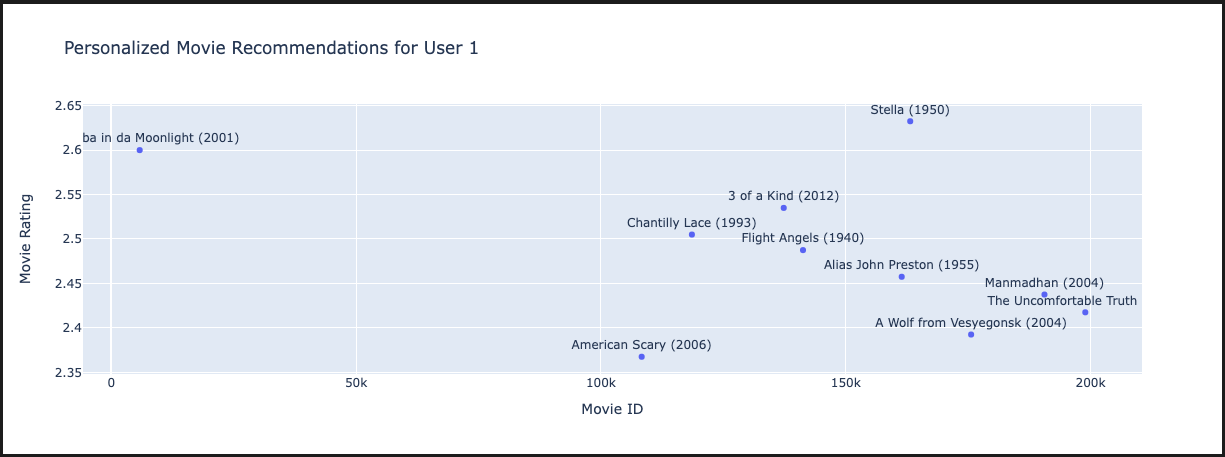

In [12]:
display(Image(filename='https://github.com/kariemoorman/didactic-diy/blob/main/tutorials/recommendation/images/img_1.png'))

In [127]:
# Create an interactive scatter plot
fig = go.Figure()

# Add scatter trace
fig.add_trace(
    go.Scatter(
        x=movie_data_df_results['movieId'],
        y=movie_data_df_results['mean_ratings'],
        text=movie_data_df_results['title'],
        mode='markers',
        marker=dict(
            size=10,
            color='blue',
            opacity=0.7,
            line=dict(width=1, color='DarkSlateGrey')
        ),
        hovertemplate='<b>Movie Title</b>: %{text}<br>'
                      '<b>Movie ID</b>: %{x}<br>'
                      '<b>Movie Rating</b>: %{y}<extra></extra>', 
    )
)

# Set axis labels and title
fig.update_layout(
    title=f'Personalized Movie Recommendations for User {target_user}',
    xaxis_title='Movie ID',
    yaxis_title='Movie Rating',
)

# Show the plot
fig.show()

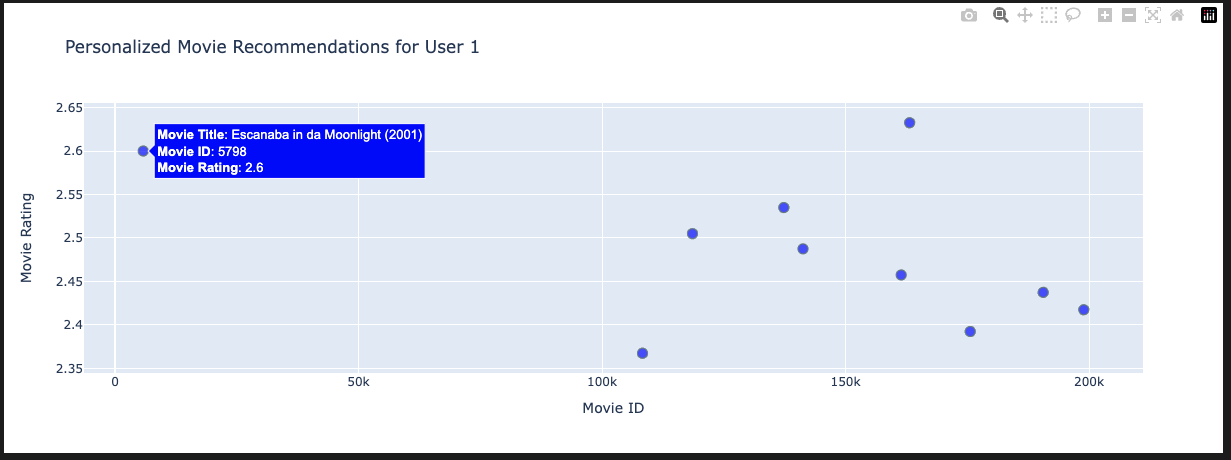

In [15]:
display(Image(filename='https://github.com/kariemoorman/didactic-diy/blob/main/tutorials/recommendation/images/img_2.png'))